In [1]:
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import pickle

### Random Search

In [13]:
# Step 1: Prepare the data
dfw = pd.read_csv('../../features/weekly_feat.csv').drop(columns=['year', 'week'])
dfw = dfw[dfw['price_per_kg'] <= 5]
dfw['posting_date'] = pd.to_datetime(dfw['posting_date'])
dfw.set_index('posting_date', inplace=True)

cat_feats = list(dfw.select_dtypes(include=['object']).columns)

In [5]:
X = dfw.drop(columns=['price_per_kg'])
y = dfw['price_per_kg']

# Step 2: Split the data temporally
train_size = int(len(dfw) * 0.8)  # 80% for training, 20% for testing
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 3: Initialize CatBoost Regressor
catboost_model = CatBoostRegressor(cat_features=cat_feats, verbose=0)

# Step 4: Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [200, 300, 500],  # Number of boosting iterations
    'learning_rate': [0.01, 0.02, 0.05],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [3, 5, 10],
    'random_strength': [1, 2, 3],
    'od_wait': [20, 30],
    'min_data_in_leaf': [5, 10, 20],
    'grow_policy': ['Lossguide'],
    'max_leaves': [20, 30, 40],
    'random_seed': [42]
}

# Step 5: Perform RandomizedSearchCV
tscv = TimeSeriesSplit(n_splits=4)
random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_dist,
    n_iter=20,  # Number of parameter settings to sample
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Step 6: Get the best parameters and model
best_params = random_search.best_params_
print(f"Best parameters: {best_params}")

best_model = random_search.best_estimator_

# Step 7: Evaluate the model on the test set
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Fitting 4 folds for each of 20 candidates, totalling 80 fits
Best parameters: {'random_strength': 2, 'random_seed': 42, 'od_wait': 20, 'n_estimators': 500, 'min_data_in_leaf': 5, 'max_leaves': 40, 'learning_rate': 0.02, 'l2_leaf_reg': 5, 'grow_policy': 'Lossguide', 'depth': 4}
Mean Squared Error: 0.015203211341980856


### Retrain on all data and save model

In [3]:
def time_series_split(df, test_size=0.2):
    """
    Perform a time series split for train and test sets.

    Parameters:
    - df: DataFrame, the dataset with 'posting_date' as index
    - test_size: Proportion of the dataset to use for testing (default is 0.2)

    Returns:
    - X_train: Training features
    - y_train: Training target
    - X_test: Test features
    - y_test: Test target
    - date_train: Dates for training set
    - date_test: Dates for testing set
    """
    # Ensure the dataframe is sorted by index
    df_sorted = df.sort_index()

    # Calculate the split point for chronological train-test split
    split_index = int(len(df_sorted) * (1 - test_size))

    # Split data chronologically
    X_train = df_sorted.iloc[:split_index].drop(columns=['price_per_kg'])
    y_train = df_sorted.iloc[:split_index]['price_per_kg']

    X_test = df_sorted.iloc[split_index:].drop(columns=['price_per_kg'])
    y_test = df_sorted.iloc[split_index:]['price_per_kg']

    return X_train, y_train, X_test, y_test


In [4]:
def create_time_series_catboost(df, param_set, test_size=0.2):
    """
    Train a CatBoost model with the optimal hyperparameters.

    Parameters:
    - df: DataFrame, the dataset
    - param_set: CatBoost's hyper param set
    - test_size: Proportion of the dataset to use for testing (default is 0.2)

    Returns:
    - model: Trained CatBoost model
    """
    
    # Split the dataset using time series split
    X_train, y_train, X_test, y_test = time_series_split(df, test_size)

    # Identifying categorical features
    categorical_features = list(X_train.select_dtypes(include=['object']).columns)
    
    # Initialize the CatBoost model with the optimal parameters
    model = CatBoostRegressor(**param_set)

    # Train the model
    model.fit(X_train, y_train, cat_features=categorical_features)

    # Predict on test set
    y_pred_test = model.predict(X_test)
    
    # Predict on train set for performance comparison
    y_pred_train = model.predict(X_train)
    
    # Calculate metrics on the test set
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    r2_test = r2_score(y_test, y_pred_test)
    
    # Prepare results dataframe
    results_df = pd.DataFrame({
        'product': X_test['product'],
        'actual_price': y_test,
        'predicted_price': y_pred_test
    }, index=X_test.index)
    
    # # Visualize results by product
    # unique_products = results_df['product'].unique()
    # plt.figure(figsize=(20, 4 * len(unique_products)))
    
    # for i, product in enumerate(unique_products, 1):
    #     product_data = results_df[results_df['product'] == product]
        
    #     plt.subplot(len(unique_products), 1, i)
    #     # Use the index (posting_date) for the x-axis
    #     plt.scatter(product_data.index, product_data['actual_price'], 
    #                 color='blue', label='Actual Prices', alpha=0.7)
    #     plt.scatter(product_data.index, product_data['predicted_price'], 
    #                 color='red', label='Predicted Prices', alpha=0.7)
    #     plt.title(f'Actual vs Predicted Prices - {product}')
    #     plt.xlabel('Date')
    #     plt.ylabel('Price per kg')
    #     plt.legend()
    #     plt.xticks(rotation=45)
    
    # plt.tight_layout()
    # plt.show()
    
    # Feature importance
    feature_names = X_train.columns
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Return results including both train and test metrics
    return {
        'model': model,
        'metrics': {
            'Test_MAE': mae_test,
            'Test_MSE': mse_test,
            'Test_RMSE': rmse_test,
            'Test_R2': r2_test
        },
        'feature_importance': feature_importance,
        'results_df': results_df
    }


In [5]:
def print_model_results(results):
    print("Model Performance Metrics:")
    for metric, value in results['metrics'].items():
        print(f"{metric}: {value:.4f}")
    
    print("\nTop 10 Most Important Features:")
    print(results['feature_importance'].head(10))

0:	learn: 0.2515061	total: 231ms	remaining: 1m 55s
100:	learn: 0.1190681	total: 8.96s	remaining: 35.4s
200:	learn: 0.1027285	total: 14.8s	remaining: 22.1s
300:	learn: 0.0975412	total: 20s	remaining: 13.3s
400:	learn: 0.0938673	total: 24.8s	remaining: 6.11s
499:	learn: 0.0911104	total: 29.2s	remaining: 0us


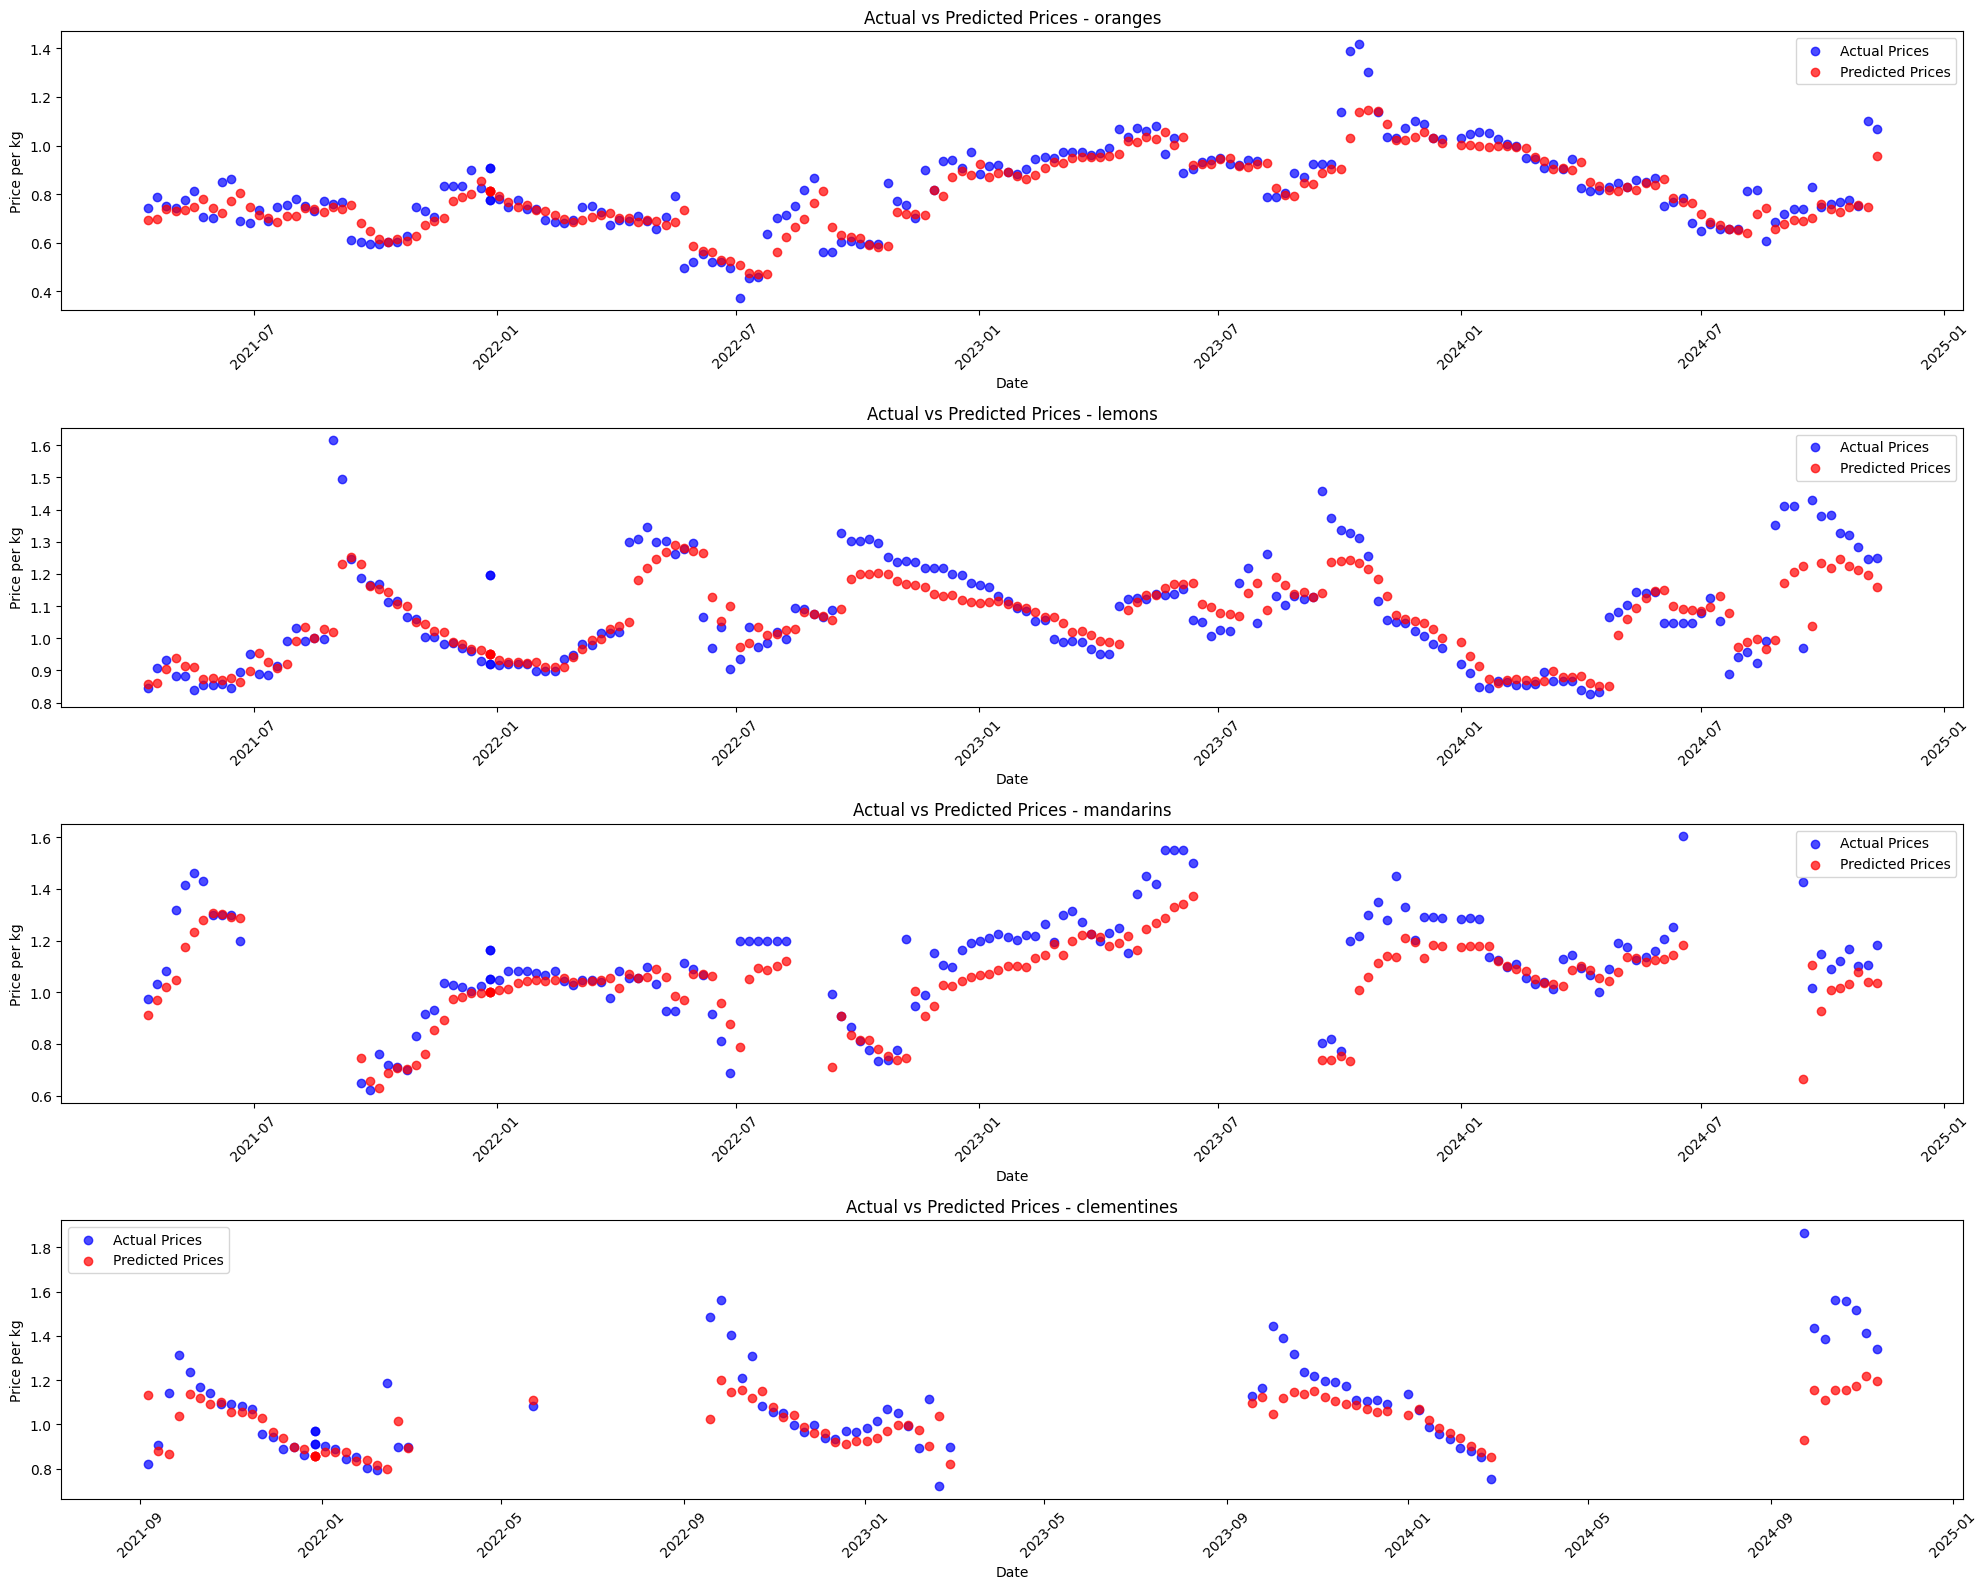

In [ ]:
week_param_set = {
    'random_strength': 2,
    'random_seed': 42,
    'od_wait': 20,
    'n_estimators': 500,
    'min_data_in_leaf': 5,
    'max_leaves': 40,
    'learning_rate': 0.02,
    'l2_leaf_reg': 5,
    'grow_policy': 'Lossguide',
    'depth': 4,
    'verbose': 100,
    'loss_function': 'RMSE'
}
res = create_time_series_catboost(dfw, week_param_set)

In [16]:
print_model_results(res)

Model Performance Metrics:
Train_MAE: 0.0555
Train_MSE: 0.0083
Train_RMSE: 0.0910
Train_R2: 0.8722
Test_MAE: 0.0769
Test_MSE: 0.0152
Test_RMSE: 0.1233
Test_R2: 0.6870

Top 10 Most Important Features:
      feature  importance
24     lag_1w   66.434841
25     lag_2w    9.584282
26     lag_3w    6.915468
27     lag_4w    5.877898
0     product    3.183271
28     lag_5w    2.032115
29     lag_6w    1.635827
13  egypt_tem    0.469034
19  spain_tem    0.381718
16     sa_tem    0.267644


In [19]:
# # Save the dictionary to a file
# with open('../../result/weekly_model.pkl', 'wb') as f:
#     pickle.dump(res['model'], f)

In [7]:
dfm = pd.read_csv('../../features/monthly_feat.csv')
dfm['posting_date'] = pd.to_datetime(dfm['posting_date'])
dfm.set_index('posting_date', inplace=True)

In [53]:
month_param_set = {
    'iterations': 1500,
    'learning_rate': 0.01,
    'depth': 4,
    'random_state': 42,
    'loss_function': 'RMSE',
    'verbose': 100,
    'l2_leaf_reg': 4
}
res = create_time_series_catboost(dfm, month_param_set)
print_model_results(res)

0:	learn: 0.2718691	total: 38.1ms	remaining: 57.1s
100:	learn: 0.2049904	total: 3.75s	remaining: 51.9s
200:	learn: 0.1811841	total: 6.82s	remaining: 44.1s
300:	learn: 0.1711910	total: 9.87s	remaining: 39.3s
400:	learn: 0.1652933	total: 12.6s	remaining: 34.4s
500:	learn: 0.1607908	total: 15.2s	remaining: 30.4s
600:	learn: 0.1572347	total: 17.6s	remaining: 26.3s
700:	learn: 0.1536235	total: 20.1s	remaining: 22.9s
800:	learn: 0.1504832	total: 22.8s	remaining: 19.9s
900:	learn: 0.1466728	total: 25.2s	remaining: 16.7s
1000:	learn: 0.1439203	total: 27.5s	remaining: 13.7s
1100:	learn: 0.1415914	total: 30s	remaining: 10.9s
1200:	learn: 0.1391155	total: 32.5s	remaining: 8.09s
1300:	learn: 0.1366197	total: 34.9s	remaining: 5.34s
1400:	learn: 0.1331617	total: 37.6s	remaining: 2.66s
1499:	learn: 0.1308563	total: 40.2s	remaining: 0us
Model Performance Metrics:
Test_MAE: 0.1293
Test_MSE: 0.0313
Test_RMSE: 0.1769
Test_R2: 0.3599

Top 10 Most Important Features:
            feature  importance
26     

In [47]:
# # Save the dictionary to a file
# with open('../../result/monthly_model.pkl', 'wb') as f:
#     pickle.dump(res['model'], f)

In [37]:
# week_param_set = {'random_strength': 2, 'random_seed': 42, 'od_wait': 30, 'n_estimators': 300, 'min_data_in_leaf': 5, 'max_leaves': 30, 'learning_rate': 0.01, 'l2_leaf_reg': 4, 'grow_policy': 'Lossguide', 'depth': 4, 'verbose': 0, 'loss_function': 'RMSE'}
# res = create_time_series_catboost(dfw.drop(columns=['spain_dsubgroup', 'spain_ppl_affected',
#        'spain_dcount', 'spain_no_disaster', 'egypt_dsubgroup',
#        'egypt_ppl_affected', 'egypt_dcount', 'egypt_no_disaster',
#        'south africa_dsubgroup', 'south africa_ppl_affected',
#        'south africa_dcount', 'south africa_no_disaster', 'egypt_tariff', 'sa_tariff']), week_param_set)
# print_model_results(res)

Model Performance Metrics:
Test_MAE: 0.0783
Test_MSE: 0.0157
Test_RMSE: 0.1255
Test_R2: 0.6760

Top 10 Most Important Features:
      feature  importance
10     lag_1w   62.831045
11     lag_2w   16.140428
12     lag_3w    7.385154
13     lag_4w    3.926699
0     product    2.916963
15     lag_6w    2.111391
14     lag_5w    2.099341
1   egypt_tem    0.474851
4      sa_tem    0.443661
7   spain_tem    0.411125


In [39]:
# month_param_set = {'iterations': 1500, 'learning_rate': 0.02, 'depth': 5, 'random_state': 42, 'loss_function': 'RMSE', 'verbose': 100, 'l2_leaf_reg': 4}
# res = create_time_series_catboost(dfm.drop(columns=['spain_dsubgroup', 'spain_ppl_affected',
#        'spain_dcount', 'spain_no_disaster', 'egypt_dsubgroup',
#        'egypt_ppl_affected', 'egypt_dcount', 'egypt_no_disaster',
#        'south africa_dsubgroup', 'south africa_ppl_affected',
#        'south africa_dcount', 'south africa_no_disaster', 'egypt_tariff', 'sa_tariff']), month_param_set)
# print_model_results(res)

0:	learn: 0.2704859	total: 55.7ms	remaining: 1m 23s
100:	learn: 0.1763750	total: 3.92s	remaining: 54.3s
200:	learn: 0.1577983	total: 7.16s	remaining: 46.3s
300:	learn: 0.1476519	total: 10.2s	remaining: 40.6s
400:	learn: 0.1379347	total: 13.3s	remaining: 36.3s
500:	learn: 0.1290452	total: 16.3s	remaining: 32.5s
600:	learn: 0.1212539	total: 18.9s	remaining: 28.3s
700:	learn: 0.1146340	total: 21.5s	remaining: 24.5s
800:	learn: 0.1081995	total: 24.3s	remaining: 21.2s
900:	learn: 0.1029855	total: 27.5s	remaining: 18.3s
1000:	learn: 0.0984782	total: 30.3s	remaining: 15.1s
1100:	learn: 0.0944928	total: 33s	remaining: 12s
1200:	learn: 0.0908270	total: 35.8s	remaining: 8.91s
1300:	learn: 0.0874287	total: 39s	remaining: 5.96s
1400:	learn: 0.0843401	total: 42s	remaining: 2.97s
1499:	learn: 0.0816882	total: 44.7s	remaining: 0us
Model Performance Metrics:
Test_MAE: 0.1327
Test_MSE: 0.0322
Test_RMSE: 0.1794
Test_R2: 0.3418

Top 10 Most Important Features:
              feature  importance
12        